In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
def get_coords(multiplication_factor,t_slab_x,t_slab_y,t_slab_z):
    x_size,y_size,z_size = t_slab_x/multiplication_factor,t_slab_y/multiplication_factor,t_slab_z
    coordinates_slabs=[]
    for i in range(multiplication_factor):
        for j in range(multiplication_factor):
            center_x = (i - ( multiplication_factor/ 2) + 0.5) * x_size
            center_y = (j - ( multiplication_factor/ 2) + 0.5) * y_size
            center_z = 0  # All cubes are centered on the z=0 plane
            coord_item = {
                    "X": (center_x - x_size/2, center_x + x_size/2),
                    "Y": (center_y - y_size/2, center_y + y_size/2),
                    "Z": (-z_size/2, z_size/2),
                    "center": (center_x, center_y, center_z)
                    }
            
            coordinates_slabs+=[coord_item]

    return coordinates_slabs

In [25]:
# Function to create a solid cylinder with specified center coordinates
def create_cylinder_from_ends(top_center, bottom_center, radius):
    # Calculate height of the cylinder
    height = np.linalg.norm(np.array(top_center) - np.array(bottom_center))
    bottom_center=bottom_center

    # Calculate the vector direction of the cylinder
    axis_direction = np.array(top_center) - np.array(bottom_center)
    axis_direction /= np.linalg.norm(axis_direction) #Unitary vector to calculate rotation angle 

    # Calculate the rotation matrix to align cylinder with the given axis direction
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, axis_direction)
    rotation_angle = np.arccos(np.dot(z_axis, axis_direction))
    rotation_matrix = mesh.Mesh.rotation_matrix(rotation_axis, rotation_angle)
    matrix_4x4 = np.eye(4)
    matrix_4x4[:3, :3] = rotation_matrix
    cylinder_center = tuple((np.array(top_center) + np.array(bottom_center))/2)
    trans = td.Transformed.translation(*cylinder_center)
    transformed = td.Transformed(geometry=td.Cylinder(center=(0,0,0), radius=radius, length=height),transform=trans@matrix_4x4)

    return transformed

In [26]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [171]:
lambdas = np.array([7,3])
filename = rf"D:\MPB Code and structures\20250731 New Structures res 256\Elongated\structures_res_256_n_3.40_scaling_perp_0.4\ak4_1000_ends_rad_0.616_eps_ff_0.2000.h5"
project_name = "20250902 Test Hollow Rods"
postprocess_results = []
runtime_ps = 15e-12
min_steps_per_lambda = 20
multiplication_factor = 1

if os.path.isfile(filename):
    structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=filename
                                    ,direction="z", lambda_range=lambdas,
                                    box_size=14.3,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                                   scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                   monitors=["flux"], freqs=280, 
                                   cut_condition=1, source="planewave", absorbers=200, use_permittivity=False,
                                       ref_only=False, multiplicate_size=True,multiplication_factor=multiplication_factor,width=0.4
                                       )
    # structure_1.plot_sim_layout()
           
        # print(structure_1.__str__())

            



Configured successfully.


16:51:21 W. Europe Daylight Time WARNING: Structure at 'structures[0]' has      
                                 bounds that extend exactly to simulation edges.
                                 This can cause unexpected behavior. If         
                                 intending to extend the structure to infinity  
                                 along one dimension, use td.inf as a size      
                                 variable instead to make this explicit.        

                                 WARNING: Suppressed 3 WARNING messages.        

In [172]:
# file_path =  r"H:\phd stuff\tidy3d\structures\End2EndFiles\Florescu Uncut\ak4_1000_ends.dat"
file_path = r"H:\phd stuff\tidyExamples\code_from_ends\ak4_1000_ends_no_headers.dat"
data = []
with open(file_path, 'r') as file:
    for line in file: 
        row = [float(value) for value in line.split()]
        data += [np.array(row)]

data = np.array(data)

tops_centered = (data[:,:3])
bottoms_centered = (data[:,3:])

radius = 0.2
coords = get_coords(structure_1.multiplication_factor,structure_1.t_slab_x,structure_1.t_slab_y,structure_1.t_slab_z)
all_node_coords = [] # 1. Initialize a list to collect all node coordinates
scale_factors = (1, 1, 1)

cyl_group = []

for k,coord in enumerate(coords):
    tops = np.copy(tops_centered)
    bottoms = np.copy(bottoms_centered)
    tops[:,0]+=coord["center"][0]
    tops[:,1]+=coord["center"][1]
    tops[:,2]+=coord["center"][2]
    bottoms[:,0]+=coord["center"][0]
    bottoms[:,1]+=coord["center"][1]
    bottoms[:,2]+=coord["center"][2]

    all_node_coords.extend(tops)
    all_node_coords.extend(bottoms)

    for cil,item in enumerate(tops):
         cyl_group.append(create_cylinder_from_ends(tops[cil], bottoms[cil], radius))

    
   


In [ ]:
medium=td.Medium(permittivity=1)
structure = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group).rotated(-np.pi/2,axis=1).rotated(np.pi,axis=1), medium=medium)

In [174]:
sim = structure_1.sim
sim = sim.copy(update={"structures":[
    structure_1.sim.structures[0],
    structure
]})
# sim.plot_3d()

16:51:24 W. Europe Daylight Time WARNING: Structure at 'structures[0]' has      
                                 bounds that extend exactly to simulation edges.
                                 This can cause unexpected behavior. If         
                                 intending to extend the structure to infinity  
                                 along one dimension, use td.inf as a size      
                                 variable instead to make this explicit.        

                                 WARNING: Suppressed 3 WARNING messages.        

<Figure size 1600x1200 with 0 Axes>

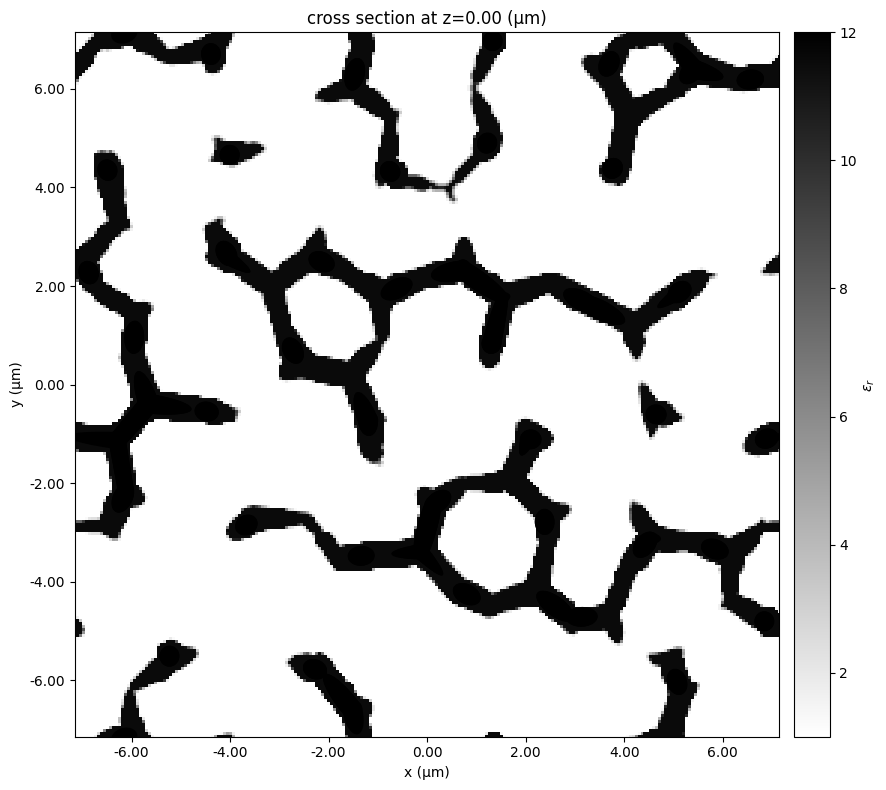

In [175]:
plt.figure(dpi=250)
freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
sim.plot_eps(z=0, freq=freqs_plot[0], ax=ax)
plt.show()
